In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame(pd.read_csv('/kaggle/input/champagne-sales/perrin-freres-monthly-champagne.csv', header=0, index_col=0, parse_dates=True))
series = df.columns[0]
df.head()

,Sales in Millions
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


# Exploratory Data Analysis

In [3]:
print(df.shape)
print(df.isnull().sum())

(105, 1)
Sales in Millions    0
dtype: int64


In [4]:
import statsmodels.tsa.api as smt
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

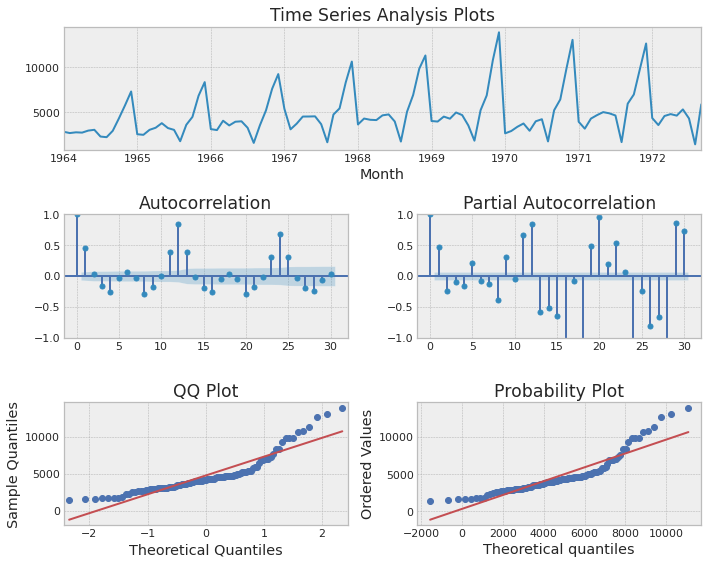

In [5]:
tsplot(df[series], lags=30)

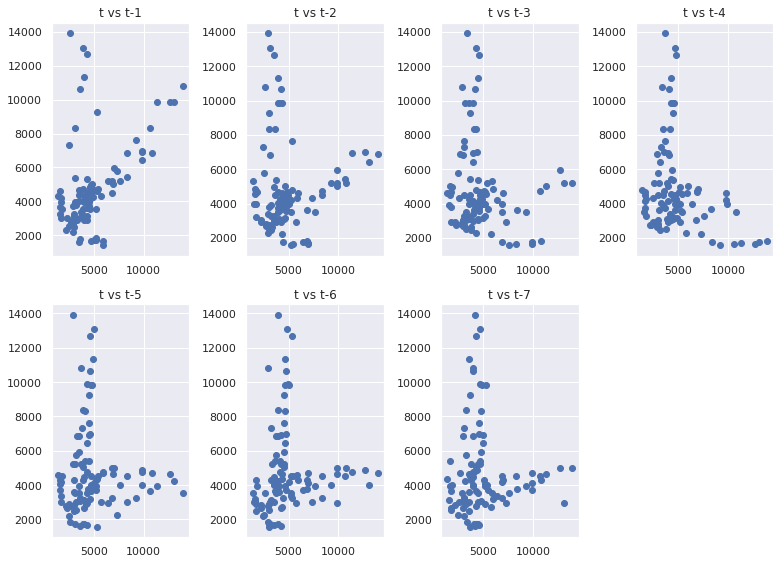

In [6]:
plt.figure(figsize=(11,8))

values = pd.DataFrame(df.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.tight_layout()
plt.show()

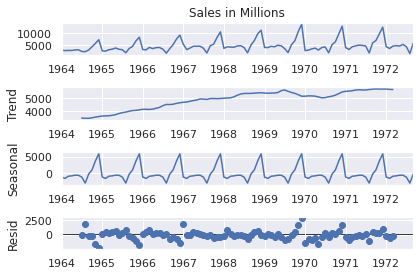

In [7]:
decomposed = sm.tsa.seasonal_decompose(df[series],period=12)
figure = decomposed.plot()
plt.show()

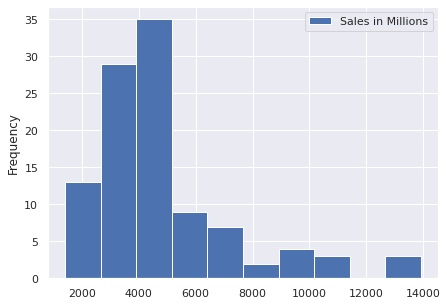

In [8]:
df.plot(kind='hist', figsize=(7,5));

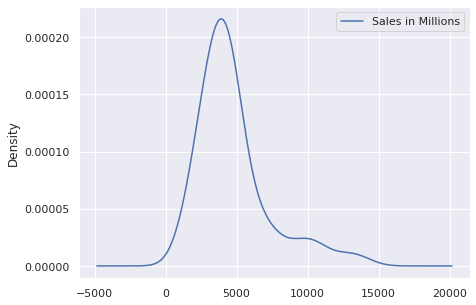

In [9]:
df.plot(kind='kde', figsize=(7,5));

# Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

adf(df[series])

Test-Statistic: -1.8335930563276188
P-Value: 0.363915771660247
Non-Stationary


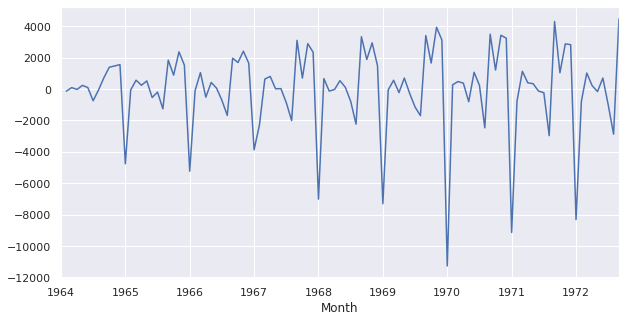

In [11]:
df['diff1'] = df[series].diff()
df['diff1'].plot(figsize=(10,5));

In [12]:
df.dropna(axis=0, how='any', inplace=True)
adf(df['diff1'])

Test-Statistic: -7.189896448051
P-Value: 2.519620447387081e-10
Stationary


# Error Metrics

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))

# Naive/Persistence Forecast

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
try:
    df.drop(columns='diff1', inplace=True)
except:
    pass
df.head()

try:
    df.drop(columns='EWMA', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0


MAPE: 44.23%
RMSE: 2651
MAE: 1721
R2: -0.08


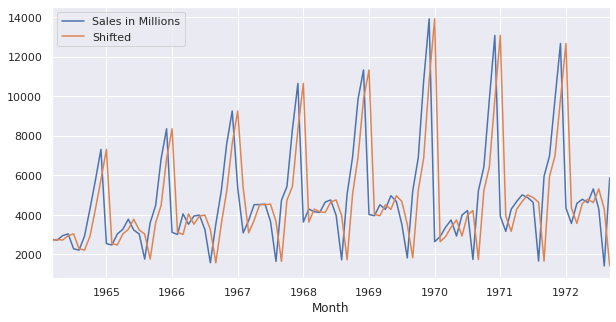

In [15]:
df_copy = df
df_copy['Shifted'] = df_copy[series].shift(1)
df_copy.dropna(axis=0, how='any', inplace=True)

mape_result = mape(df_copy[series], df_copy['Shifted'])
rmse_result = rmse(df_copy[series], df_copy['Shifted'])
mae_result = mean_absolute_error(df_copy[series], df_copy['Shifted'])
r2_result = r2_score(df_copy[series], df_copy['Shifted'])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

df_copy[[series, 'Shifted']].plot();

# Double Exponential Smoothing

In [16]:
try:
    df.drop(columns='Shifted', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0


In [17]:
from statsmodels.tsa.holtwinters import Holt
holt = Holt(df[series])
result = holt.fit(optimized=True)
result.params

{'smoothing_level': 0.0757142857142857,
 'smoothing_trend': 0.05506493506493506,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 2755.0,
 'initial_trend': -34.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

MAPE: 38.55%
RMSE: 2574
MAE: 1867
MAE: -4.08


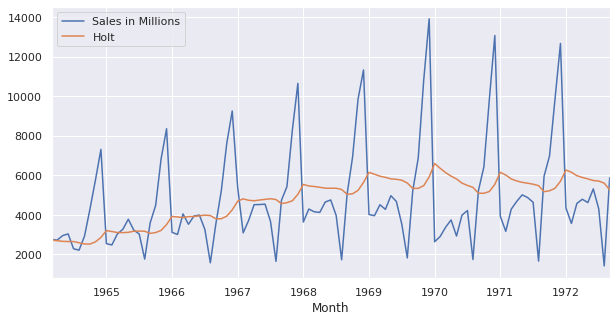

In [18]:
df['Holt'] = result.predict(start=df.index[0], end=df.index[-1])

mape_result = mape(df['Holt'], df[series])
rmse_result = rmse(df['Holt'], df[series])
mae_result = mean_absolute_error(df['Holt'], df[series])
r2_result = r2_score(df['Holt'], df[series])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('MAE: %.2f' % r2_result)

df.plot(figsize=(10,5));

### Walkforward Validation

In [19]:
from statsmodels.tsa.holtwinters import Holt

In [20]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

n_test = 24
X = df[series].values
train, test = train_test_split(X, n_test)

In [21]:
def forecast(history, param_model):
    model = param_model(history)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [22]:
def walkforward_val(history, param_model):
    predictions = list()
    history = [x for x in train]
    
    for i in range(len(test)):
        yhat = forecast(history, param_model)
        predictions.append(yhat)
        history.append(test[i])
    
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    r2_result = r2_score(test, predictions)
    
    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    print('R2: %.2f' % r2_result)

    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

MAPE: 66.31%
RMSE: 3633
MAE: 2760
R2: -0.58


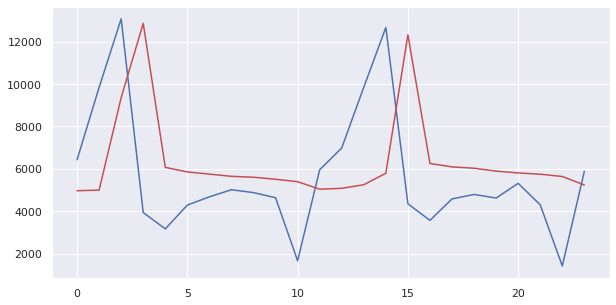

In [23]:
predictions = walkforward_val(train, Holt)

# Triple Exponential Smoothing

In [24]:
try:
    df.drop(columns='Holt', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0


In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [26]:
data = df[series].values
train, test = train_test_split(data,n_test)

In [27]:
def exp_smoothing_forecast(history,t,d,s,p):
    model = ExponentialSmoothing(history, 
                                 trend=t, 
                                 damped=d, 
                                 seasonal=s, 
                                 seasonal_periods=p)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [28]:
def walkforward_validation(history,t,d,s,p):
    predictions = list()
    history = [x for x in train]
    for i in range(len(test)):
        yhat = exp_smoothing_forecast(history,t,d,s,p)
        predictions.append(yhat)
        history.append(test[i])
    error = rmse(test, predictions)
    return error

### Parameter Searching

In [29]:
print('additive, no damping')
history = [x for x in train]
for p in (2,3,4,5,6,7,8,9,10,12,24):
    error = walkforward_validation(history, 'add', False, 'add', p)
    msg = "p=%.0f:, RMSE=%.0f" % (p, error)
    print(msg)

additive, no damping
p=2:, RMSE=3371
p=3:, RMSE=3017
p=4:, RMSE=3220
p=5:, RMSE=3701
p=6:, RMSE=2347
p=7:, RMSE=3514
p=8:, RMSE=3270
p=9:, RMSE=3533
p=10:, RMSE=3538
p=12:, RMSE=580
p=24:, RMSE=1123


In [30]:
print('multiplicative, no damping')
for p in (2,3,4,5,6,7,8,9,10,12,24):
    error = walkforward_validation(history, 'mul', False, 'mul', p)
    msg = "p=%.0f:, RMSE=%.0f" % (p, error)
    print(msg)

multiplicative, no damping
p=2:, RMSE=3380
p=3:, RMSE=nan
p=4:, RMSE=nan
p=5:, RMSE=3524
p=6:, RMSE=nan
p=7:, RMSE=nan
p=8:, RMSE=2762
p=9:, RMSE=nan
p=10:, RMSE=nan
p=12:, RMSE=nan
p=24:, RMSE=nan


In [31]:
print('additive, with damping')
for p in (2,3,4,5,6,7,8,9,10,12,24):
    error = walkforward_validation(history, 'add', True, 'add', p)
    msg = "p=%.0f:, RMSE=%.0f" % (p, error)
    print(msg)

additive, with damping
p=2:, RMSE=3406
p=3:, RMSE=2976
p=4:, RMSE=3342
p=5:, RMSE=3912
p=6:, RMSE=2331
p=7:, RMSE=3612
p=8:, RMSE=3622
p=9:, RMSE=3172
p=10:, RMSE=3516
p=12:, RMSE=560
p=24:, RMSE=935


### Walkforward Validation

MAPE: 10.38%
RMSE: 580
MAE: 425
R2: 0.96


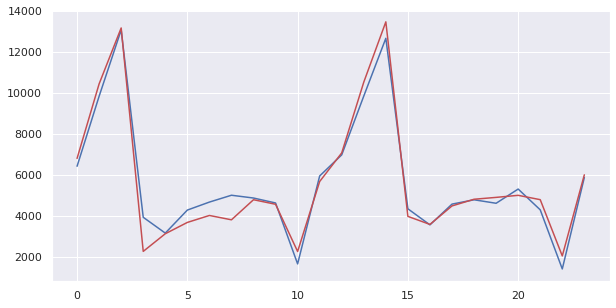

In [32]:
t = 'add'
d = False
s = 'add'
p = 12

predictions = list()
history = [x for x in train]
for i in range(len(test)):
    yhat = exp_smoothing_forecast(history,t,d,s,p)
    predictions.append(yhat)
    history.append(test[i])
    
mape_result = mape(test, predictions)
rmse_result = rmse(test, predictions)
mae_result = mean_absolute_error(test, predictions)
r2_result = r2_score(test, predictions)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(test);
plt.plot(predictions, color='r');

#### Analysis of Residuals

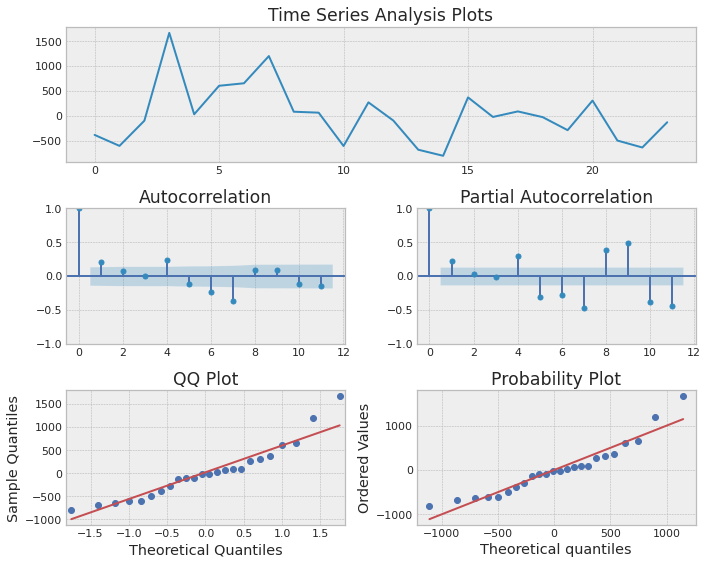

In [33]:
residuals = test - predictions
tsplot(residuals, lags=11)

In [34]:
adf(residuals)

Test-Statistic: -2.1109007978230365
P-Value: 0.2401539879544461
Non-Stationary


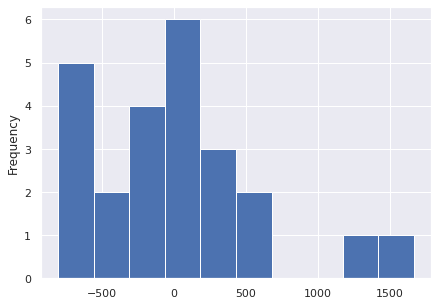

In [35]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

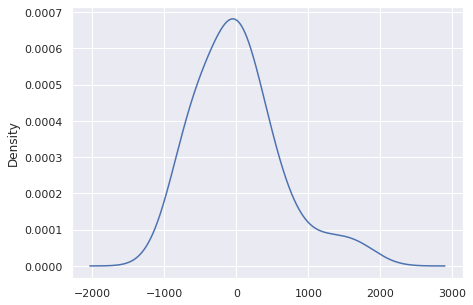

In [36]:
res.plot(kind='kde', figsize=(7,5));

### Multi-Step Prediction

MAPE: 12.72%
RMSE: 707
MAE: 501
R2: 0.92


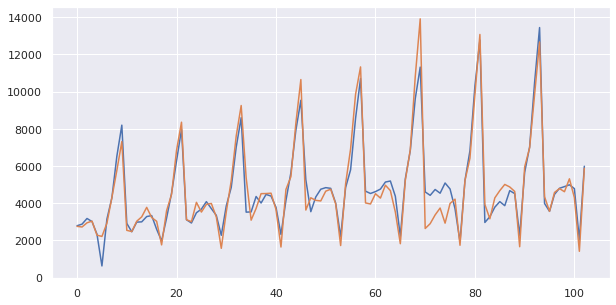

In [37]:
model = ExponentialSmoothing(history, 
                             trend=t, 
                             damped=d, 
                             seasonal=s, 
                             seasonal_periods=p)
model_fit = model.fit(optimized=True)
yhat = model_fit.predict(0, len(history) - 1)

mape_result = mape(history, yhat)
rmse_result = rmse(history, yhat)
mae_result = mean_absolute_error(history, yhat)
r2_result = r2_score(history, yhat)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(yhat);
plt.plot(history);

#### Analysis of Residuals

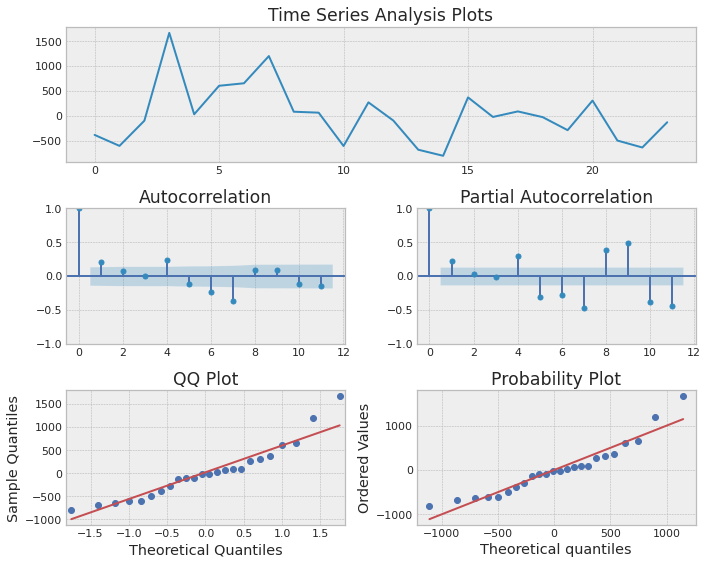

In [38]:
residuals = test - predictions
tsplot(residuals, lags=11)

In [39]:
adf(residuals)

Test-Statistic: -2.1109007978230365
P-Value: 0.2401539879544461
Non-Stationary


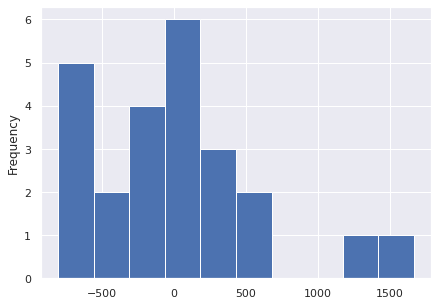

In [40]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

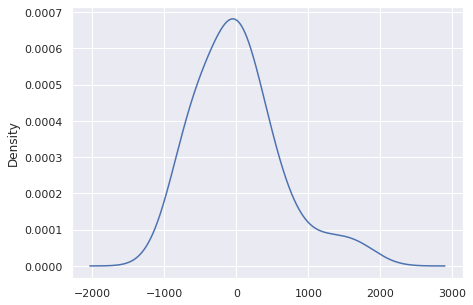

In [41]:
res.plot(kind='kde', figsize=(7,5));

# ARIMA

In [42]:
try:
    df.drop(columns='Holt', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0


### Parameter Searching

In [43]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [44]:
import pmdarima as pm

In [45]:
model = pm.auto_arima(train[:],
                      trace=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1434.883, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1456.311, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1438.709, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1434.399, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1575.758, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1437.146, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1436.441, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1438.410, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1507.036, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.657 seconds


### Walkforward Validation

In [46]:
from statsmodels.tsa.arima.model import ARIMA

In [47]:
p = 0
d = 0
q = 1
order = (p,d,q)

In [48]:
def evaluate_arima_model(X, n_test):
    
    train_size = int(len(X) - n_test)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(order))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    r2_result = r2_score(test, predictions)

    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    print('MAPE: %.2f' % r2_result)
    
    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

MAPE: 44.17%
RMSE: 2716
MAE: 2054
MAPE: 0.12


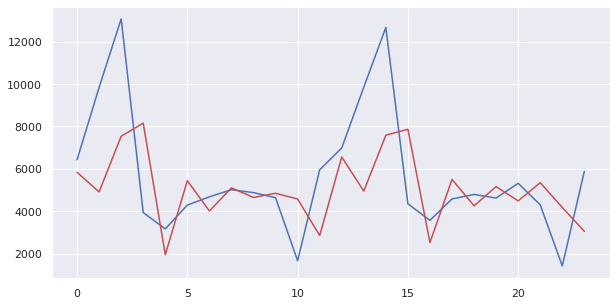

In [49]:
predictions = evaluate_arima_model(df[series].values, n_test)

### Multi-Step Prediction

In [50]:
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

str_order = str(order)
arima = ARIMA(train[series], order=order)
arima_result = arima.fit()
df.loc[train_idx, 'AR %s' % str_order] = arima_result.predict(start=train.index[0], end=train.index[-1])

prediction = arima_result.get_forecast(n_test)
forecast = pd.Series(prediction.predicted_mean)
df.loc[test_idx, 'AR %s' % str_order] = forecast

MAPE: 36.19%
RMSE: 3081
MAE: 1870
R2: -0.13


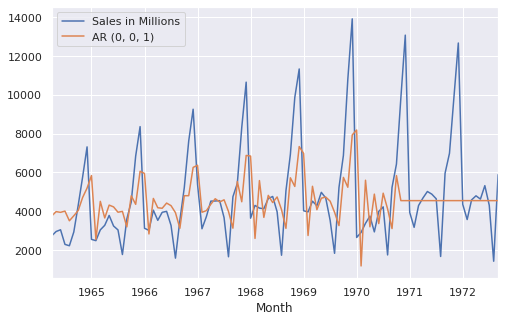

In [51]:
train, test = train_test_split(df, n_test)

mape_result = mape(test[series], test['AR %s' % str_order])
rmse_result = rmse(test[series], test['AR %s' % str_order])
mae_result = mean_absolute_error(test[series], test['AR %s' % str_order])
r2_result = r2_score(test[series], test['AR %s' % str_order])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

df_copy = df.iloc[1:]
df_copy[[series, 'AR %s' % str_order]].plot(figsize=(8, 5));

# SARIMA

In [52]:
try:
    train.drop(columns='AR %s' % str_order, inplace=True)
except:
    pass

try:
    test.drop(columns='AR %s' % str_order, inplace=True)
except:
    pass

try:
    df.drop(columns='AR %s' % str_order, inplace=True)
except:
    pass

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Parameter Searching

In [54]:
model = pm.auto_arima(train[:],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1079.602, Time=1.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1104.628, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1092.167, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1074.708, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1072.726, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1074.695, Time=0.39 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1076.013, Time=1.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1074.380, Time=0.16 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1074.347, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1092.467, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1074.461, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 4.468 seconds


In [55]:
p = 0
d = 0
q = 0
P = 0
D = 1
Q = 0
m = 12
order = (p,d,q)
s_order = (P,D,Q,m)

### Walkforward Validation

In [56]:
def evaluate_sarima_model(X, n_test):
    
    train_size = int(len(X) - n_test)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=(order), seasonal_order=(s_order))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    r2_result = r2_score(test, predictions)

    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    print('R2: %.2f' % r2_result)
    
    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92785D+00    |proj g|=  1.94573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      6      1     0     0   2.557D-06   6.922D+00
  F =   6.9217618435070545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      6      1     0     0   1.621D-06   7.087D+00
  F =   7.0868916802630846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09827D+00    |proj g|=  1.65034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16659D+00    |proj g|=  1.54241D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   2.272D-06   7.163D+00
  F =   7.1628364061875889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


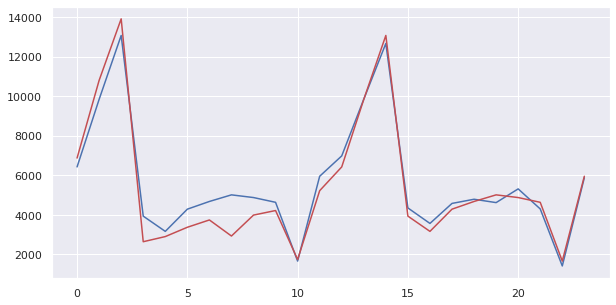

In [57]:
predictions = evaluate_sarima_model(df[series].values, n_test)

#### Analysis of Residuals

In [58]:
adf(residuals)

Test-Statistic: -2.1109007978230365
P-Value: 0.2401539879544461
Non-Stationary


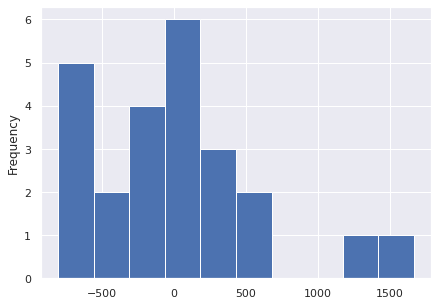

In [59]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

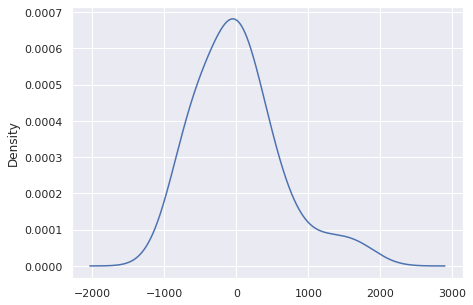

In [60]:
res.plot(kind='kde', figsize=(7,5));

### Multi-Step Prediction

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92785D+00    |proj g|=  1.94573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      6      1     0     0   2.557D-06   6.922D+00
  F =   6.9217618435070545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAPE: 14.49%
RMSE: 853
MAE: 648
R2: 0.88


 This problem is unconstrained.


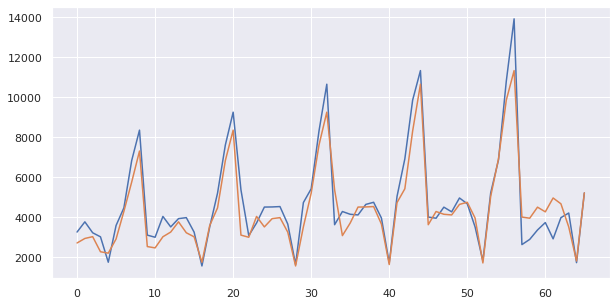

In [61]:
model = SARIMAX(train[:], order=(0,0,0), seasonal_order=(0,1,0,12))
result = model.fit()
train_pred = result.predict(0, len(train) - 1)

train_copy = np.array([x for x in train[series][13:]])
train_pred_copy = np.array([x for x in train_pred[13:]])

mape_result = mape(train_copy, train_pred_copy)
rmse_result = rmse(train_copy, train_pred_copy)
mae_result = mean_absolute_error(train_copy, train_pred_copy)
r2_result = r2_score(train_copy, train_pred_copy)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(train_copy)
plt.plot(train_pred_copy);

In [62]:
test_pred = result.predict(len(train), len(train) + len(test) - 1)

MAPE: 17.35%
RMSE: 1014
MAE: 870
R2: 0.88


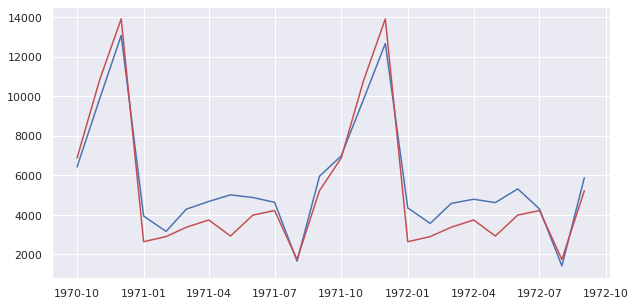

In [63]:
test_copy = np.array([x for x in test[series]])
test_pred_copy = np.array([x for x in test_pred])

mape_result = mape(test_copy, test_pred_copy)
rmse_result = rmse(test_copy, test_pred_copy)
mae_result = mean_absolute_error(test_copy, test_pred_copy)
r2_result = r2_score(test_copy, test_pred_copy)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(test)
plt.plot(test_pred, color='r');

#### Analysis of Residuals

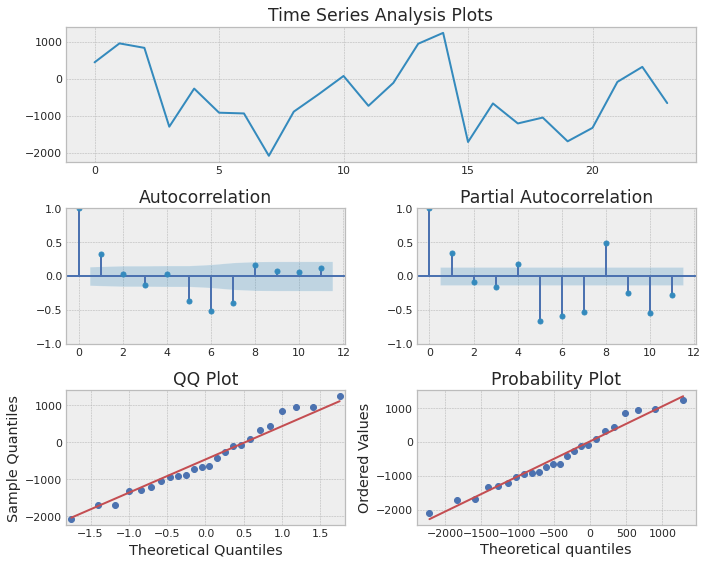

In [64]:
residuals = test_pred_copy - test_copy
tsplot(residuals, lags=11)

In [65]:
adf(residuals)

Test-Statistic: -2.4255567837211216
P-Value: 0.13465272428876307
Non-Stationary


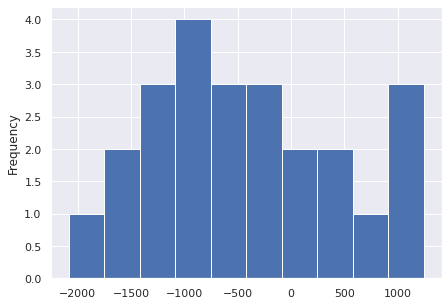

In [66]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

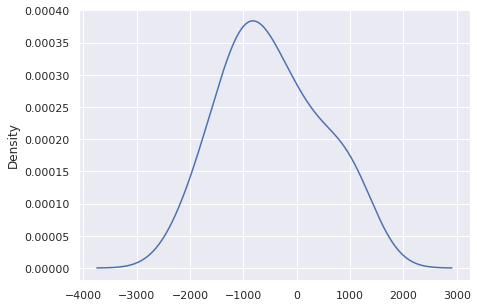

In [67]:
res.plot(kind='kde', figsize=(7,5));